Objeto 1:
  Color: azul
  Área: 4551.50
  Perímetro: 308.21
  Centroide: (1287, 882)
Objeto 2:
  Color: azul
  Área: 4554.00
  Perímetro: 307.14
  Centroide: (1218, 845)
Objeto 3:
  Color: naranja
  Área: 14650.50
  Perímetro: 582.32
  Centroide: (407, 871)
Objeto 4:
  Color: verde
  Área: 8889.50
  Perímetro: 639.63
  Centroide: (960, 883)
Objeto 6:
  Color: rojo
  Área: 10156.50
  Perímetro: 457.40
  Centroide: (140, 865)
Objeto 7:
  Color: amarillo
  Área: 9999.50
  Perímetro: 533.35
  Centroide: (708, 865)
Objeto 8:
  Color: azul
  Área: 20633.50
  Perímetro: 740.34
  Centroide: (1242, 669)
Objeto 9:
  Color: verde
  Área: 10233.00
  Perímetro: 414.68
  Centroide: (975, 664)
Objeto 10:
  Color: amarillo
  Área: 6560.00
  Perímetro: 457.36
  Centroide: (716, 652)
Objeto 12:
  Color: rojo
  Área: 10597.00
  Perímetro: 1020.81
  Centroide: (147, 635)
Objeto 14:
  Color: naranja
  Área: 21709.00
  Perímetro: 1044.61
  Centroide: (411, 638)
Objeto 17:
  Color: rojo
  Área: 10156.50
  Pe

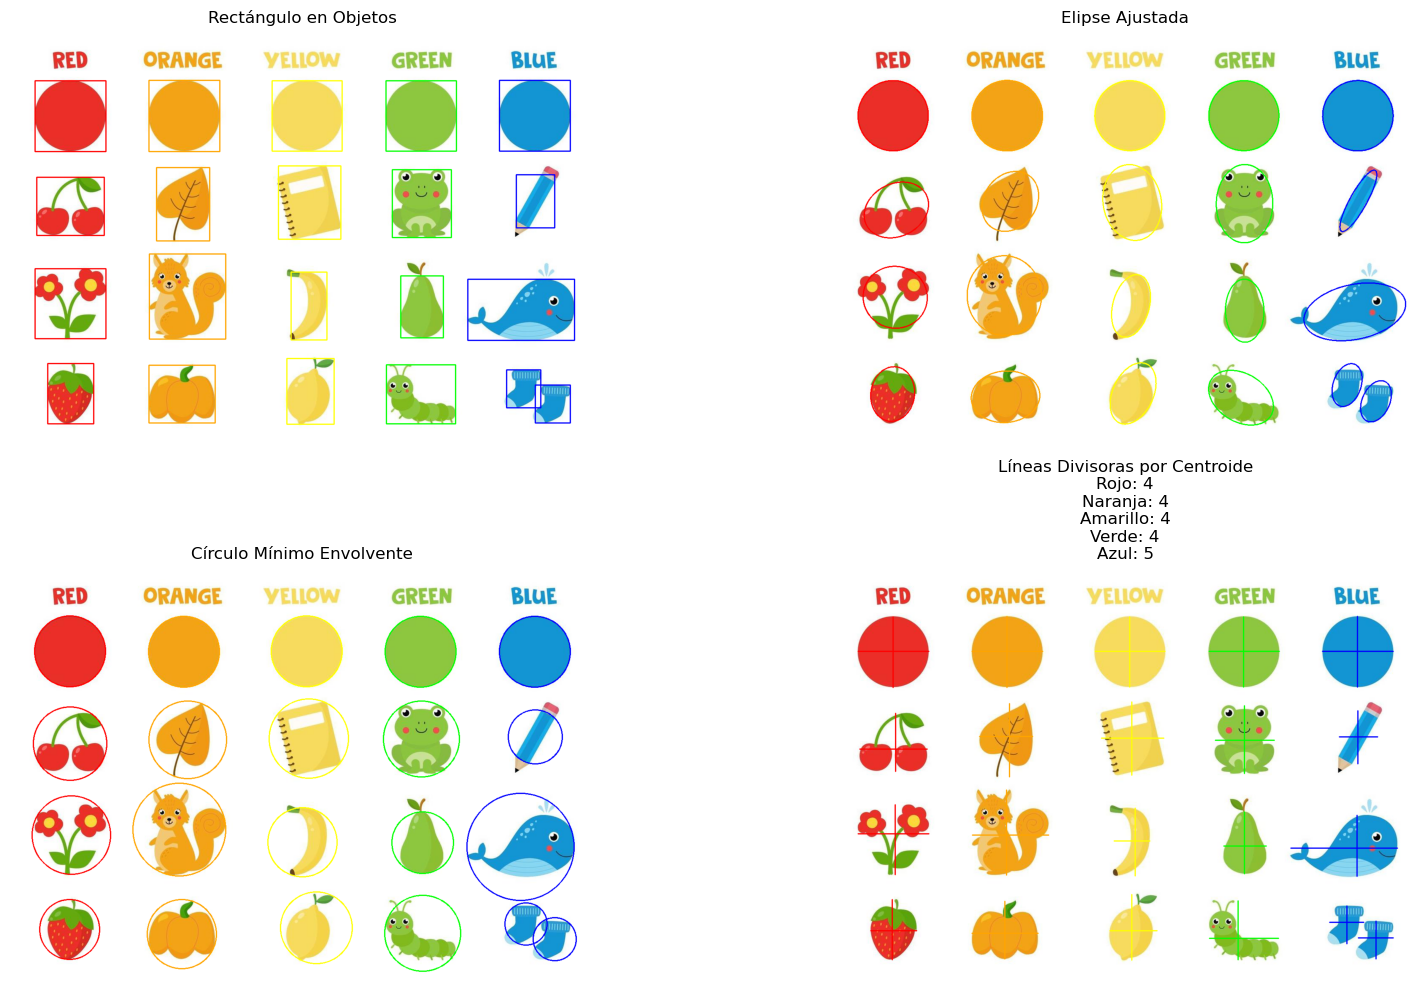

In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

imagen = cv2.imread('colores.jpg')
hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

rangos_colores = {
    'rojo':    ((np.array([0, 100, 100]), np.array([10, 255, 255])), (0, 0, 255)),
    'naranja': ((np.array([11, 100, 100]), np.array([20, 255, 255])), (0, 165, 255)),
    'amarillo':((np.array([21, 100, 100]), np.array([30, 255, 255])), (0, 255, 255)),
    'verde':   ((np.array([35, 100, 100]), np.array([85, 255, 255])), (0, 255, 0)),
    'azul':    ((np.array([86, 100, 100]), np.array([125, 255, 255])), (255, 0, 0)),
}

mascara_global = np.zeros(hsv.shape[:2], dtype=np.uint8)
mascaras_individuales = {}

for nombre, (rango, _) in rangos_colores.items():
    mascara = cv2.inRange(hsv, rango[0], rango[1])
    kernel = np.ones((5, 5), np.uint8)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel)
    mascara_global = cv2.bitwise_or(mascara_global, mascara)
    mascaras_individuales[nombre] = mascara

contornos, _ = cv2.findContours(mascara_global, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rect = imagen.copy()
img_ellipse = imagen.copy()
img_circle = imagen.copy()
img_center_lines = imagen.copy()
conteo_colores = Counter()

for i, contorno in enumerate(contornos, 1):
    area = cv2.contourArea(contorno)
    if area < 800:
        continue

    x, y, w, h = cv2.boundingRect(contorno)
    aspecto = w / h if h != 0 else 0
    perimetro = cv2.arcLength(contorno, True)
    aprox = cv2.approxPolyDP(contorno, 0.02 * perimetro, True)

    if aspecto < 0.2 or aspecto > 1.9 or len(aprox) < 4:
        continue

    mask_objeto = np.zeros(hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask_objeto, [contorno], -1, 255, -1)

    pixeles_por_color = {}
    for nombre, mascara_color in mascaras_individuales.items():
        interseccion = cv2.bitwise_and(mascara_color, mask_objeto)
        pixeles_por_color[nombre] = cv2.countNonZero(interseccion)

    color_predominante = max(pixeles_por_color, key=pixeles_por_color.get)
    color_bgr = rangos_colores[color_predominante][1]
    conteo_colores[color_predominante] += 1

    M = cv2.moments(contorno)
    if M["m00"] == 0:
        continue
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    print(f"Objeto {i}:")
    print(f"  Color: {color_predominante}")
    print(f"  Área: {area:.2f}")
    print(f"  Perímetro: {perimetro:.2f}")
    print(f"  Centroide: ({cx}, {cy})")

    cv2.rectangle(img_rect, (x, y), (x + w, y + h), color_bgr, 2)
    if len(contorno) >= 5:
        ellipse = cv2.fitEllipse(contorno)
        cv2.ellipse(img_ellipse, ellipse, color_bgr, 2)
    (xc, yc), radio = cv2.minEnclosingCircle(contorno)
    cv2.circle(img_circle, (int(xc), int(yc)), int(radio), color_bgr, 2)
    cv2.line(img_center_lines, (cx, y), (cx, y + h), color_bgr, 2)
    cv2.line(img_center_lines, (x, cy), (x + w, cy), color_bgr, 2)

titulo = "\n".join([f"{color.capitalize()}: {conteo_colores[color]}" for color in rangos_colores])

plt.figure(figsize=(18, 10))

plt.subplot(221)
plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
plt.title("Rectángulo en Objetos")
plt.axis("off")

plt.subplot(222)
plt.imshow(cv2.cvtColor(img_ellipse, cv2.COLOR_BGR2RGB))
plt.title("Elipse Ajustada")
plt.axis("off")

plt.subplot(223)
plt.imshow(cv2.cvtColor(img_circle, cv2.COLOR_BGR2RGB))
plt.title("Círculo Mínimo Envolvente")
plt.axis("off")

plt.subplot(224)
plt.imshow(cv2.cvtColor(img_center_lines, cv2.COLOR_BGR2RGB))
plt.title("Líneas Divisoras por Centroide\n" + titulo)
plt.axis("off")

plt.tight_layout()
plt.show()


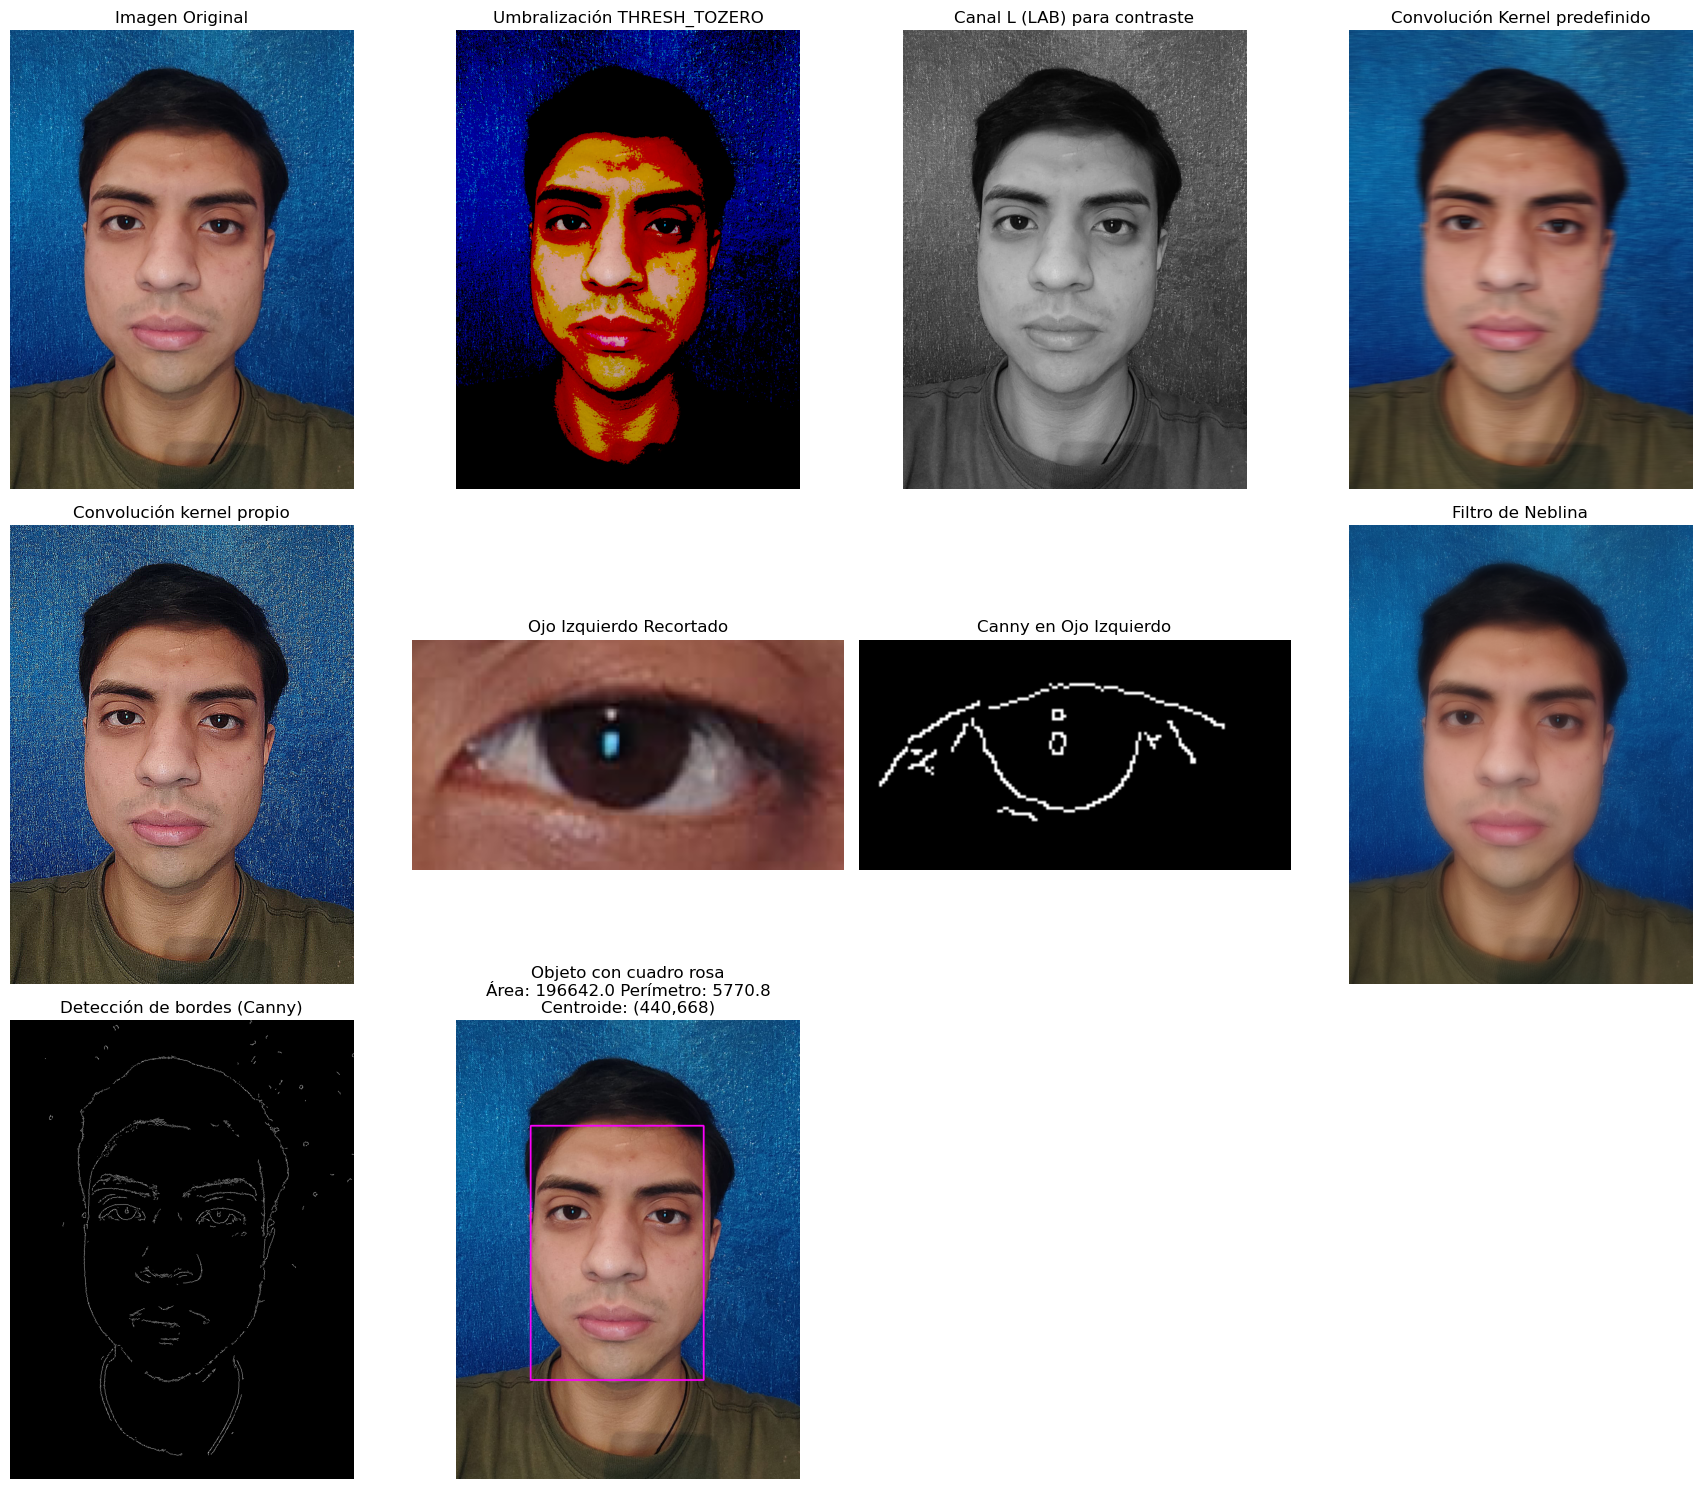

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convolucion_media_horizontal(imagen, tamanioKernel):
    kernel = np.ones((1, tamanioKernel), np.float32) / tamanioKernel
    imgfin = cv2.filter2D(imagen, -1, kernel)
    return imgfin

img = cv2.imread('foto_cara.jpeg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_, umbral_tozero = cv2.threshold(img_rgb, 127, 200, cv2.THRESH_TOZERO)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
canal_l = img_lab[:, :, 0]

kernel_size = 25
img_rest_r = convolucion_media_horizontal(img_rgb[:, :, 0], kernel_size)
img_rest_g = convolucion_media_horizontal(img_rgb[:, :, 1], kernel_size)
img_rest_b = convolucion_media_horizontal(img_rgb[:, :, 2], kernel_size)
imgcolor_media_horizontal = np.stack([img_rest_r, img_rest_g, img_rest_b], axis=2).astype(np.uint8)

kernel_sharpen = np.array([[ -1, -1, -1],
                           [ -1,  9, -1],
                           [ -1, -1, -1]])
img_sharpen = cv2.filter2D(img, -1, kernel_sharpen)
img_sharpen_rgb = cv2.cvtColor(img_sharpen, cv2.COLOR_BGR2RGB)


img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
img_laplacian = cv2.convertScaleAbs(img_laplacian)

x_eye, y_eye, w_eye, h_eye = 520, 515, 150, 80
ojo_izq = img_rgb[y_eye:y_eye+h_eye, x_eye:x_eye+w_eye]
ojo_izq_gray = cv2.cvtColor(ojo_izq, cv2.COLOR_RGB2GRAY)

ojo_izq_blur = cv2.GaussianBlur(ojo_izq_gray, (5,5), 0)

ojo_canny = cv2.Canny(ojo_izq_blur, 100, 150)

img_blur = cv2.GaussianBlur(img, (75, 75), 0)
img_filtro_neblina = cv2.addWeighted(img, 0.4, img_blur, 0.6, 0)
img_filtro_neblina_rgb = cv2.cvtColor(img_filtro_neblina, cv2.COLOR_BGR2RGB)

img_blur = cv2.GaussianBlur(img_gray, (25, 25), 0)

img_canny = cv2.Canny(img_blur, 15, 28) 

umbral_tozero_gray = cv2.cvtColor(umbral_tozero, cv2.COLOR_RGB2GRAY)
_, umbral_bin = cv2.threshold(umbral_tozero_gray, 1, 255, cv2.THRESH_BINARY)

contornos, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contornos) > 0:
    contorno_mayor = max(contornos, key=cv2.contourArea)
    area = cv2.contourArea(contorno_mayor)
    perimetro = cv2.arcLength(contorno_mayor, True)
    M = cv2.moments(contorno_mayor)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0
else:
    area, perimetro, cx, cy = 0, 0, 0, 0

img_rect = img_rgb.copy()
x, y, w, h = cv2.boundingRect(contorno_mayor) if len(contornos) > 0 else (0,0,0,0)
cv2.rectangle(img_rect, (x,y), (x+w,y+h), (255, 0, 255), 3)

plt.figure(figsize=(18, 15))

plt.subplot(3, 4, 1)
plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(umbral_tozero)
plt.title("Umbralización THRESH_TOZERO")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(canal_l, cmap='gray')
plt.title("Canal L (LAB) para contraste")
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(imgcolor_media_horizontal)
plt.title("Convolución Kernel predefinido")
plt.axis('off')

plt.subplot(3, 4, 5)
plt.imshow(img_sharpen_rgb)
plt.title("Convolución kernel propio")
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(ojo_izq)
plt.title("Ojo Izquierdo Recortado")
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(ojo_canny, cmap='gray')
plt.title("Canny en Ojo Izquierdo")
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(img_filtro_neblina_rgb)
plt.title("Filtro de Neblina")
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(img_canny, cmap='gray')
plt.title("Detección de bordes (Canny)")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(img_rect)
plt.title(f"Objeto con cuadro rosa\nÁrea: {area:.1f} Perímetro: {perimetro:.1f}\nCentroide: ({cx},{cy})")
plt.axis('off')

plt.tight_layout()
plt.show()


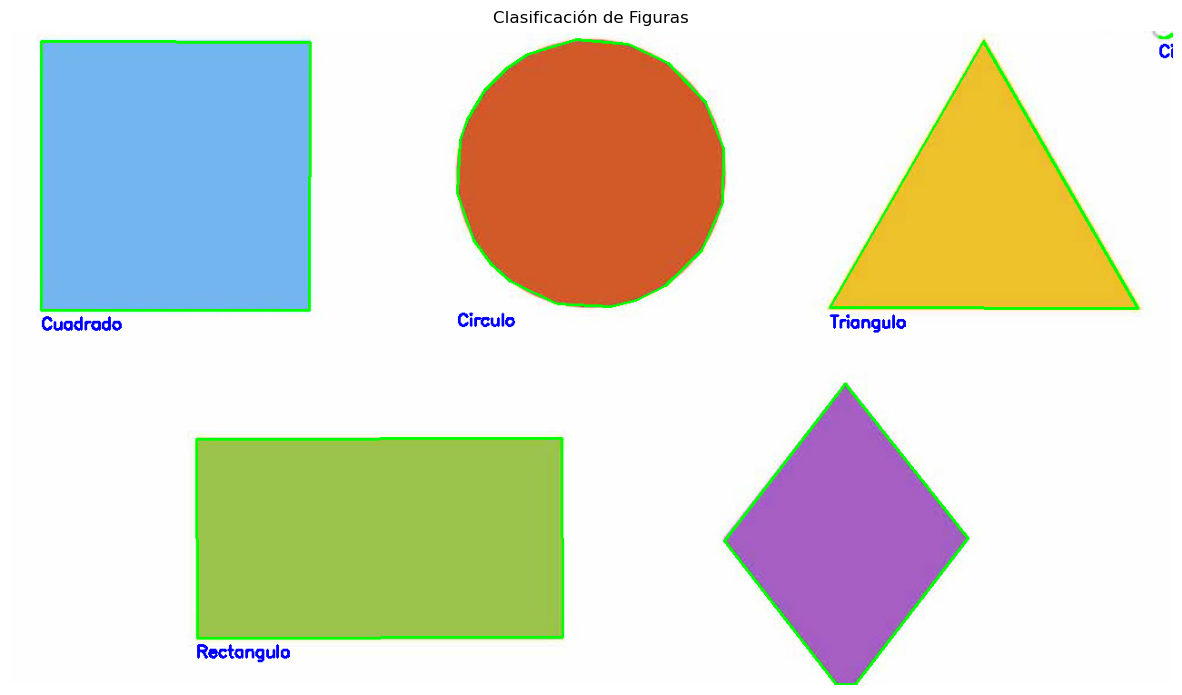

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('figuras.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
bin = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY_INV)[1]
contornos = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

for cnt in contornos:
    epsilon = 0.003 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    momentos = cv2.moments(cnt)
    forma = "Indefinido"
    vertices = len(approx)
    if vertices == 3:
        forma = "Triangulo"
    elif vertices == 4:
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w)/h
        forma = "Cuadrado" if 0.95 <= aspect_ratio <= 1.05 else "Rectangulo"
    elif vertices > 5:
        forma = "Circulo"
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.putText(img, forma, (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Clasificación de Figuras")
plt.show()


Conteo de Monedas 

Monedas detectadas ordenadas de izquierda a derecha:
1: PosX=46, Radio=40, Valor=0.10 Bs
2: PosX=135, Radio=43, Valor=0.20 Bs
3: PosX=231, Radio=47, Valor=5.00 Bs
4: PosX=335, Radio=52, Valor=1.00 Bs
5: PosX=450, Radio=57, Valor=2.00 Bs
6: PosX=559, Radio=48, Valor=0.50 Bs


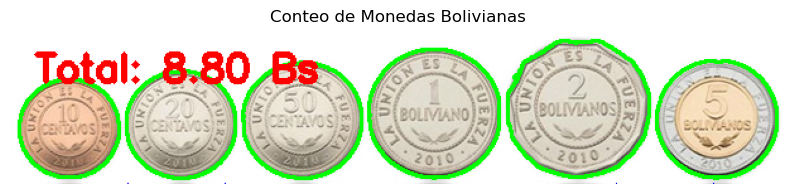

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('monedasboli.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

bin = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

contornos, _ = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_contada = img.copy()
total = 0.0

monedas = []

for contorno in contornos:
    area = cv2.contourArea(contorno)
    if area < 300:
        continue

    (cx, cy), radio = cv2.minEnclosingCircle(contorno)
    radio = int(radio)
    cx, cy = int(cx), int(cy)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (cx, cy), radio, 255, -1)

    moneda_roi = cv2.bitwise_and(img, img, mask=mask)

    pixels = moneda_roi[mask == 255]
    pixels = pixels.reshape(-1, 3)
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    counts = np.bincount(labels.flatten())
    porcentajes = counts / counts.sum() * 100
    umbral_min = 30
    tiene_cambio_color = np.all(porcentajes > umbral_min)

    if radio <= 42:
        valor = 0.10
    elif radio <= 45:
        valor = 0.20
    elif radio <= 49:
        valor = 5.00 if tiene_cambio_color else 0.50
    elif radio <= 54:
        valor = 1.00
    elif radio <= 60:
        valor = 2.00
    else:
        valor = 0.0

    total += valor

    (x, y, w_rect, h_rect) = cv2.boundingRect(contorno)
    cv2.drawContours(img_contada, [contorno], -1, (0, 255, 0), 2)
    texto = f"{valor:.2f} Bs | R: {radio} | Cambio color:{tiene_cambio_color}"
    cv2.putText(img_contada, texto, (x, y + h_rect + 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    monedas.append((cx, radio, valor))

monedas_ordenadas = sorted(monedas, key=lambda m: m[0])

print("Monedas detectadas ordenadas de izquierda a derecha:")
for i, (cx, radio, valor) in enumerate(monedas_ordenadas, 1):
    print(f"{i}: PosX={cx}, Radio={radio}, Valor={valor:.2f} Bs")

cv2.putText(img_contada, f"Total: {total:.2f} Bs", (20, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

img_rgb = cv2.cvtColor(img_contada, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Conteo de Monedas Bolivianas")
plt.show()
